# Comparison between different preprocessing methods

Attached, you also find the code for the standard spectral pre-processing,
along with a description of the steps (from the eLife paper) and two data
files used by the code. Please, implement this in your code and do a
comparison using PCA. <br>
I?m also attaching the metafile with the lung-cancer cohort. You can
compare the different pre-processing methods (standard vs autoencoder) on
this classification problem and see if autoencoders can provide an increase
on the AUC. For this, I?m attaching the classification code (calculation
of AUC using SVM classifier with cross-validation) and the code to import
the cases and controls.  

## Loading the data

In [1]:
import pandas as pd
import numpy as np

path_data = r"\\z-sv-dfsroot\dfsroot\project\agzigman\MIRA Anaylzer - Eval\L4L_all_samples\Serum" # path to the folder with measurements
df = pd.read_excel(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\LuCa_VS_NSR.xlsx")

vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

In [2]:
###---###---###  Import  ###---###---###
import pandas as pd
import os.path 
import json

#path_data = r"\\z-sv-dfsroot\dfsroot\project\agzigman\MIRA Anaylzer - Eval\L4L_all_samples\Serum" # path to the folder with measurements
#df = pd.read_excel(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\LuCa_VS_NSR.xlsx")

cancer = df[df.cancer_status==1]
healthy = df[df.cancer_status==0]
list_Healthy = healthy.filename  
list_Cancer = cancer.filename

df_Healthy = pd.DataFrame()
for name in list_Healthy:
    json_file = os.path.join(path_data, str(name))
    json_file = json_file + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            data = json.load(f)
        data = pd.DataFrame(np.flip(data['AB Data']))
        frame_Healthy = pd.DataFrame(data).T
        frame_Healthy['filename'] = os.path.basename(json_file)
        df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)

df_Cancer = pd.DataFrame()
for name in list_Cancer:
    json_file = os.path.join(path_data, str(name))
    json_file = json_file + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            data = json.load(f)
        data = pd.DataFrame(np.flip(data['AB Data']))
        frame_Cancer = pd.DataFrame(data).T
        frame_Cancer['filename'] = os.path.basename(json_file)
        df_Cancer = df_Cancer.append(frame_Cancer, ignore_index=True)

# df_Healthy = pd.DataFrame()
# for name in list_Healthy:
#     csv = os.path.join(path_data, str(name))
#     vec = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[0])[0].values
#     frame_Healthy = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[1]).T
#     frame_Healthy['filename'] = os.path.basename(csv)
#     df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
#
# df_Cancer = pd.DataFrame()
# for name in list_Cancer:
#     csv = os.path.join(path_data, str(name))
#     # vec = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[0])[0].values
#     frame_Cancer = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[1]).T
#     frame_Cancer['filename'] = os.path.basename(csv)
#     df_Cancer = df_Cancer.append(frame_Cancer, ignore_index=True)


df_Healthy = df_Healthy.set_index('filename')
df_Cancer = df_Cancer.set_index('filename')
df_Cancer['Label'] = 1
df_Healthy['Label'] = 0

df_FTIR = df_Healthy.append(df_Cancer)
y_data = df_FTIR[['Label']].values.T[0]
df_FTIR = df_FTIR.drop(['Label'], axis=1)

df_FTIR.columns = vec_
df_FTIR = df_FTIR.T
df_FTIR = df_FTIR[(df_FTIR.index>1000) & (df_FTIR.index<3000)]
df_FTIR = df_FTIR.T

x_data = df_FTIR.values
vec=df_FTIR.columns

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_8904\3106165964.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_8904\3106165964.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_8904\3106165964.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_8904\3106165964.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

Generating a train set for the autoencoder

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  6 18:28:01 2021

@author: eissa
"""

import numpy as np

def generate_spectra_v1(X, y, d, n_neg, n_pos, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=0, random_state=42):
    """
    | Parameters |
    --------------
    X : 2-D Array
        Spectra matrix with observations in rows and wavenumbers in columns.
        Matrix models the intrinsic variability around the generated samples.
    y : 1-D Array
        A vector of sample labels: 0 for controls, 1 for cases. 
        Length is equal to the number of rows in X.
    d : 1-D Array
        Discriminant vector across the wavenumbers.
        Vector models the differences in means between the postive and negative class samples across the wavenumbers.
    n_pos : Int
        Number of positive class samples to be generated.
    n_neg : Int
        Number of negative class samples to be generated.
    beta_neg_std : Float
        Standard deviation around the biological variability of the negative class samples. 
        The higher, the more variance with zero being no variance.
        Defaults to sqrt(X_neg.shape[0]), i.e., the number of negative class samples used for calibration.
    beta_pos_std : Float
        Standard deviation around the biological variability of the positive class samples. 
        The higher, the more variance with zero being no variance.
        Defaults to sqrt(X_pos.shape[0]), i.e., the number of positive class samples used for calibration.
    epsilon_std : 1-D Array
        Standard deviation around the additative white noise across the spectrum. 
        The higher, the more variance with zero being no variance.
    random_state : Int or None
        Controls the pseudo-random number generator's random seed. 
        Pass an int for reproducible results across multiple runs with the same parameters.
    | Returns |
    -----------
    Y_gen : 2-D Matrix
        Generated spectra with n_neg+n_pos observations.
    class_labels : 1-D Vector
        Labels of generated spectra.
    """
    
    # Set random state
    rand = np.random.RandomState(random_state)

    # Create a matrix for each class
    X_neg = np.array(X[y==0])
    X_pos = np.array(X[y==1])

    # Mean class vectors
    mu_neg = X_neg.mean(axis=0)
    mu_pos = X_pos.mean(axis=0)

    # Difference matrix for each class (i.e. matrix of individual differential fingerprints)
    B_neg = X_neg - np.tile(mu_neg, (X_neg.shape[0], 1))
    B_pos = X_pos - np.tile(mu_pos, (X_pos.shape[0], 1))

    # Calibrate beta coef, if 'auto', to model the variability in the given samples
    if beta_neg_std == 'auto':
        beta_neg_std = np.sqrt(X_neg.shape[0])
    if beta_pos_std == 'auto':
        beta_pos_std = np.sqrt(X_pos.shape[0])

    # Generate class samples with modeled variability using the mean measurement of controls
    Y_neg_gen = np.tile(mu_neg, (n_neg, 1)) + rand.normal(0, beta_neg_std, (X_neg.shape[0], n_neg)).T @ (B_neg/X_neg.shape[0])
    Y_pos_gen = np.tile(mu_neg, (n_pos, 1)) + rand.normal(0, beta_pos_std, (X_pos.shape[0], n_pos)).T @ (B_pos/X_pos.shape[0])
    
    # Add discriminator vector to positive class
    Y_pos_gen += np.tile(d, (n_pos, 1))

    # Put generated samples in one matrix
    Y_gen = np.vstack([Y_neg_gen, Y_pos_gen])

    # Add technical noise
    Y_gen += rand.normal(0, epsilon_std, Y_gen.shape)
    
    # Create class labels for generated samples
    class_labels = np.hstack([np.zeros(n_neg), np.ones(n_pos)])
    
    return Y_gen, class_labels

X_gen_FTIR, y_FTIR = generate_spectra_v1(df_FTIR, y_data, d=0, n_neg=2000, n_pos=2000, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=1e-2, random_state=42)

## Preprocessing with the standard method

In [4]:
print(X_gen_FTIR.shape, df_FTIR.values.shape)

(4000, 1037) (1046, 1037)


In [5]:
from scipy.signal import savgol_filter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

###---###---###  Preprocessing  ###---###---###

#---#
water = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\20201028 - warer spectrum measured by marinus.txt", sep='\t')
water = water[(water.X>1000) & (water.X<3000)]

res_all = []
ra = np.where((vec>2000) & (vec<2300))
mi = np.min(ra)
ma = np.max(ra)
y = water.Abs

for l in range(x_data.shape[0]):

    k = 0
    res = []
    for i in range(50):
        k = k + 1
        x_wc = x_data[l] + 0.001*k*y[:,None].T
        x_dev = savgol_filter(x_wc, window_length = 9, polyorder=2, deriv=1)
        res.append(np.mean(np.abs(x_dev[0][mi:ma])))
    res_all.append(res)
res_all = np.array(res_all)

weights = np.argmin(res_all,1)*0.001

x_data = x_data + np.outer(weights,y)

#---#

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

a = np.where(vec==find_nearest(vec,1000))[0][0]
b = np.where(vec==find_nearest(vec,1800))[0][0]+1
c = np.where(vec==find_nearest(vec,2800))[0][0]

vec = np.concatenate((vec[a:b],vec[c:]))
x_data = np.concatenate((x_data[:,a:b],x_data[:,c:]),1)

x_data = normalize(x_data, norm='l2')

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_8904\2451458630.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_wc = x_data[l] + 0.001*k*y[:,None].T


## Preprocessing with the autoencoder

In [6]:
train = X_gen_FTIR
test = df_FTIR.values

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
train = standardscaler.fit_transform(train)
test_scaled=standardscaler.fit_transform(test)

#reshaping the data for the model
train = train.reshape(train.shape[0],train.shape[1],1) #(number of spectra, number of points per spectra, 1 extra dim)
train.shape

(4000, 1037, 1)

In [7]:
from tensorflow import keras
layers=keras.layers

activation = "elu"
filter_size = 53
strides = 2
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(num_filters4, filter_size, strides))
model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))
model.summary()

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 493, 128)          6912      
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           434240    
                                                                 
 conv1d_2 (Conv1D)           (None, 85, 32)            108576    
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 16)            27152     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 85, 32)           27168     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 221, 64)          108608    
 ranspose)                                      

In [8]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, train,
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
29/29 [==============================] - 249s 8s/step - loss: 0.8516 - val_loss: 0.7907 - lr: 0.0010
Epoch 2/50
29/29 [==============================] - 179s 5s/step - loss: 0.7713 - val_loss: 0.7690 - lr: 0.0010
Epoch 3/50
29/29 [==============================] - 24s 818ms/step - loss: 0.7557 - val_loss: 0.7636 - lr: 0.0010
Epoch 4/50
29/29 [==============================] - 24s 822ms/step - loss: 0.7498 - val_loss: 0.7614 - lr: 0.0010
Epoch 5/50
29/29 [==============================] - 24s 813ms/step - loss: 0.7462 - val_loss: 0.7606 - lr: 0.0010
Epoch 6/50
29/29 [==============================] - 25s 852ms/step - loss: 0.7438 - val_loss: 0.7604 - lr: 0.0010
Epoch 7/50
29/29 [==============================] - 24s 830ms/step - loss: 0.7422 - val_loss: 0.7596 - lr: 0.0010
Epoch 8/50
29/29 [==============================] - 24s 811ms/step - loss: 0.7404 - val_loss: 0.7592 - lr: 0.0010
Epoch 9/50
29/29 [==============================] - 25s 866ms/step - loss: 0.7391 - val_loss

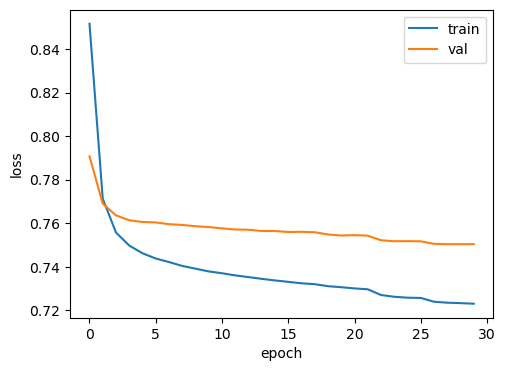

In [9]:
import matplotlib.pyplot as plt
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [20]:
import tensorflow as tf
preds = model.predict(test_scaled, verbose=1)
preds = tf.squeeze(preds)
preds_rescaled = standardscaler.inverse_transform(preds)

33/33 [==============================] - 26s 712ms/step


In [16]:
preds

<tf.Tensor: shape=(1046, 1037), dtype=float32, numpy=
array([[-0.00705177, -0.00159401, -0.00742579, ..., -0.00526303,
        -0.00340706, -0.00772095],
       [-0.00454479, -0.00147551, -0.00621891, ..., -0.00524324,
        -0.0040735 , -0.00665534],
       [-0.00529236, -0.00138122, -0.00627303, ..., -0.00572622,
        -0.00391346, -0.00682664],
       ...,
       [-0.00514275, -0.0014447 , -0.00666976, ..., -0.00468975,
        -0.00383586, -0.00695568],
       [-0.00406986, -0.00138885, -0.00628942, ..., -0.00523704,
        -0.00402176, -0.00677949],
       [-0.00509179, -0.00137991, -0.00596797, ..., -0.00519222,
        -0.00379747, -0.00746894]], dtype=float32)>

In [19]:
x_data.shape

(1046, 519)

In [11]:
"""
## Plot preprocessed and original spectra to see what has happened
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = vec #np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[1].legend(loc=1)
    ax1[i].set_xlabel('wavenumber [cm$^-1$]')
    ax2[i].set_xlabel('wavenumber [cm$^-1$]')
    ax1[i].set_ylabel('absorbance [a.u.]')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()
"""

'\n## Plot preprocessed and original spectra to see what has happened\nplots = 2\nn_test = test.shape[0]\nidx = np.random.choice(n_test, plots)\nxaxis = vec #np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])\n\nfig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))\n\nfor i in range(plots):\n    ax1[i].plot(xaxis, test[idx[i]],\'b\', markersize= 0.5, label="original spectrum")\n    ax1[i].plot(xaxis, preds_rescaled[idx[i]], \'r\', markersize=0.5, label="spectrum after autoencoder")\n    \n    ax1[1].legend(loc=1)\n    ax1[i].set_xlabel(\'wavenumber [cm$^-1$]\')\n    ax2[i].set_xlabel(\'wavenumber [cm$^-1$]\')\n    ax1[i].set_ylabel(\'absorbance [a.u.]\')\n    ax1[i].set_title("spectra")\n\n    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")\n    ax2[i].plot(xaxis, np.zeros(xaxis.shape), \'k\')\n    \n    ax2[i].set_title("residuals")\n    \nplt.tight_layout()\nplt.show()\n'

## Comparison

Plotting the ROC Curve

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

"""
#standard scaling the data
standardscaler = StandardScaler()
x_data = standardscaler.fit_transform(x_data)
x_data_std = standardscaler.fit_transform(x_data_std)
x_data_autoencoder = standardscaler.fit_transform(x_data_autoencoder)
"""

x_data_no = df_FTIR.values
#x_data_no = standardscaler.fit_transform(x_data_no)

# We will use a Support Vector Classifier with "linear" kernel
svm = SVC(kernel="linear", probability=True)
pipeline = Pipeline([('skaler', StandardScaler()),('svm', svm)])

# Set up possible values of parameters to optimize over
p_grid = {"svm__C": [10, 1, 0.0001]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)

# Nested CV with parameter optimization
clf_autoencoder = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc', n_jobs= -1)
clf_standard = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc', n_jobs= -1)
clf_no = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc', n_jobs= -1)

In [23]:
# Making predictions
predictions_autoencoder = cross_val_predict(clf_autoencoder, X = preds_rescaled, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)
predictions_standard = cross_val_predict(clf_standard, X = x_data, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)
predictions_no = cross_val_predict(clf_no, X = x_data_no, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)

#keep only positive probabilities
predictions_autoencoder = predictions_autoencoder[:,1]
predictions_standard = predictions_standard[:,1]
predictions_no = predictions_no[:,1]

#calculating the ROC curves
fpr_autoencoder, tpr_autoencoder, _ = metrics.roc_curve(y_data, predictions_autoencoder)
fpr_standard, tpr_standard, _ = metrics.roc_curve(y_data, predictions_standard)
fpr_no, tpr_no, _ = metrics.roc_curve(y_data, predictions_no)

#calculating the AUC's
auc_autoencoder = metrics.auc(fpr_autoencoder, tpr_autoencoder)
auc_standard = metrics.auc(fpr_standard, tpr_standard)
auc_no = metrics.auc(fpr_no, tpr_no)

"""
#everything for the standard method
svm = SVC(kernel="linear", probability=True)
pipeline = Pipeline([('svm', svm)])
clf_std = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc')
predictions_std = cross_val_predict(clf_std, X = x_data_no, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)
"""

'\n#everything for the standard method\nsvm = SVC(kernel="linear", probability=True)\npipeline = Pipeline([(\'svm\', svm)])\nclf_std = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring=\'roc_auc\')\npredictions_std = cross_val_predict(clf_std, X = x_data_no, y = y_data, cv\n= outer_cv, method = \'predict_proba\', n_jobs = -1)\n'

In [26]:
#calculating the AUC's 
#clf = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc')
from sklearn.model_selection import cross_val_score
nested_score_autoencoder = cross_val_score(clf_autoencoder, X=preds_rescaled, y=y_data, cv=outer_cv, scoring='roc_auc')
nested_score_nopreprocessing = cross_val_score(clf_no, X=x_data_no, y=y_data, cv=outer_cv, scoring='roc_auc')
nested_score_std = cross_val_score(clf_standard, X=x_data, y=y_data, cv=outer_cv, scoring='roc_auc')
print(nested_score_autoencoder.mean(), nested_score_autoencoder.std())
print(nested_score_nopreprocessing.mean(), nested_score_nopreprocessing.std())
print(nested_score_std.mean(), nested_score_std.std())

0.8958635703918721 0.028540083882645242
0.8916734118566483 0.02941093677835866
0.8717546332477392 0.0314792260927276


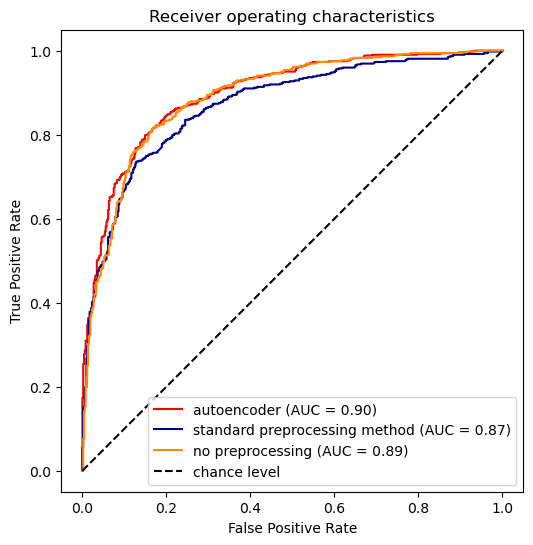

In [25]:
#sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


roc_autoencoder = RocCurveDisplay(fpr = fpr_autoencoder, 
                                  tpr = tpr_autoencoder,
                                  roc_auc= auc_autoencoder,
                                  estimator_name="autoencoder")


roc_standard_preprocessing = RocCurveDisplay(fpr = fpr_standard,
                                      tpr = tpr_standard,
                                      roc_auc = auc_standard,
                                      estimator_name="standard preprocessing method")

roc_no = RocCurveDisplay(fpr = fpr_no,
                          tpr = tpr_no,
                          roc_auc = auc_no, 
                          estimator_name="no preprocessing")

#plotting the ROC's
fig, ax = plt.subplots(figsize=(6, 6))
roc_autoencoder.plot(color="red", ax=ax)
roc_standard_preprocessing.plot(color="darkblue", ax=ax)
roc_no.plot(color= "darkorange", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristics")
plt.legend()
plt.show()


In [31]:
#extracting the silent regions
vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

range_silent = [1800, 2300]

for i in range(len(vec_)):
    if vec_[i]<range_silent[0] and vec[i+1]>=range_silent[0]:
        min_index = i+1
    if vec_[i]<=range_silent[1] and vec[i+1]>range_silent[1]:
        max_index = i
        
silent_region_autoencoder = [spect[min_index:max_index] for spect in preds_rescaled]
silent_region_autoencoder = np.array(silent_region_autoencoder)
silent_region_std = [spect[min_index:max_index] for spect in x_data]
silent_region_std = np.array(silent_region_std)
silent_region_no = [spect[min_index:max_index] for spect in x_data_no]
silent_region_no = np.array(silent_region_no)

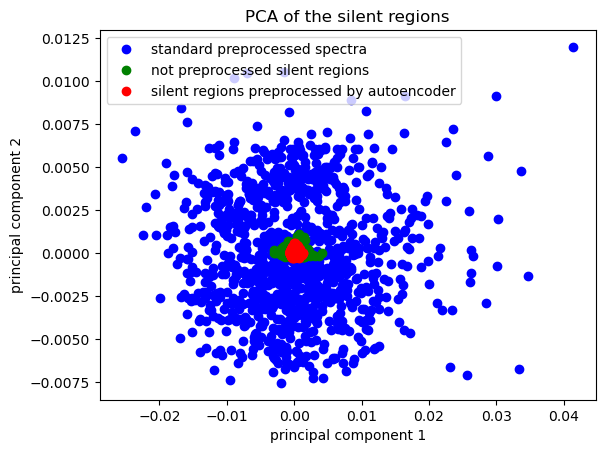

In [34]:
#PCA comparison of silent regions
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents_autoencoder = pca.fit_transform(silent_region_autoencoder)
principalComponents_std = pca.fit_transform(silent_region_std)
principalComponents_no = pca.fit_transform(silent_region_no)
principalDf_autoencoder = pd.DataFrame(data = principalComponents_autoencoder, columns = ['principal component 1', 'principal component 2'])
principalDf_std = pd.DataFrame(data = principalComponents_std, columns = ['principal component 1', 'principal component 2'])
principalDf_no = pd.DataFrame(data = principalComponents_no, columns = ['principal component 1', 'principal component 2'])

xaxis_autoencoder = list(principalDf_autoencoder["principal component 1"])
yaxis_autoencoder = list(principalDf_autoencoder["principal component 2"])
xaxis_std = list(principalDf_std["principal component 1"])
yaxis_std = list(principalDf_std["principal component 2"])
xaxis_no = list(principalDf_no["principal component 1"])
yaxis_no = list(principalDf_no["principal component 2"])


plt.plot(xaxis_std, yaxis_std, 'bo', label='standard preprocessed spectra')#, markersize= 0.5)
plt.plot(xaxis_no, yaxis_no, 'go', label='not preprocessed silent regions')#, markersize= 0.5)
plt.plot(xaxis_autoencoder, yaxis_autoencoder, 'ro', label = "silent regions preprocessed by autoencoder")#, markersize= 0.5)

plt.title("PCA of the silent regions")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()